# Querying and Expanding Neighborhood Boundaries - Extracting JEOJSON

In [1]:
import altair as alt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon

import sys
sys.path.append("../../code")
import neighborhood_boundaries

In [2]:
import importlib
importlib.reload(neighborhood_boundaries)

<module 'neighborhood_boundaries' from 'C:\\Users\\ljung\\Desktop\\git\\dsci320\\project-team_kbn\\analysis\\Picnic\\../../code\\neighborhood_boundaries.py'>

# Overview

This script demonstrates how to query neighborhood boundaries from an open data source, expand specific neighborhood boundaries, and include additional areas such as parks into the final dataset. Specifically, we focus on expanding the boundaries of West Point Grey and including Stanley Park in Vancouver's neighborhood dataset.

## 1. Fetch Local Area Boundaries
We start by querying the Local Area Boundary dataset from the City of Vancouver's Open Data Portal. This dataset contains the geographical boundaries of all neighborhoods in Vancouver.

In [3]:
# use API to get the local area boundaries
geojson_data = neighborhood_boundaries.fetch_and_save_localareaboundary_geojson("../../data/processed/local_area_boundary.geojson")

GeoJSON file '../../data/processed/local_area_boundary.geojson' has been created.


## 2. Expand West Point Grey Boundaries
To expand the boundaries of West Point Grey , I've:
- Filter the GeoJSON data to extract the polygon for "West Point Grey".
- Use the Overpass API to fetch additional boundary data
- Combine the original West Point Grey polygon with the additional polygons.

In [4]:
# west point grey 

# west point gray already exist. we want to expand the boundaries

# Filter the GeoJSON data to extract the polygon for "West Point Grey".
geojson_data = neighborhood_boundaries.load_geojson("../../data/processed/local_area_boundary.geojson")
west_point_grey_geojson = neighborhood_boundaries.filter_features_by_name(geojson_data, "West Point Grey")

#  Use the Overpass API to fetch additional boundary data
way_id_wpg1 = 341703892
coordinates_wpg1 = neighborhood_boundaries.get_boundary_by_way_id(way_id_wpg1)
park_polygon_wpg1 = Polygon(coordinates_wpg1)

way_id_wpg2 = 56688927
coordinates_wpg2 = neighborhood_boundaries.get_boundary_by_way_id(way_id_wpg2)
park_polygon_wpg2 = Polygon(coordinates_wpg2)


# Combine the original West Point Grey polygon with the additional polygons.
west_point_grey_coordinates = west_point_grey_geojson['features'][0]['geometry']['coordinates'][0]
west_point_grey_polygon = Polygon(west_point_grey_coordinates)

park_polygon_wpg1 = neighborhood_boundaries.validate_and_buffer_polygon(park_polygon_wpg1)
park_polygon_wpg2 = neighborhood_boundaries.validate_and_buffer_polygon(park_polygon_wpg2)
west_point_grey_polygon = neighborhood_boundaries.validate_and_buffer_polygon(west_point_grey_polygon)

combined_park_polygon_wpg = park_polygon_wpg1.union(park_polygon_wpg2)
final_combined_polygon = combined_park_polygon_wpg.union(west_point_grey_polygon)

combined_boundary_coordinates_wpg = neighborhood_boundaries.extract_boundary_coordinates(final_combined_polygon)

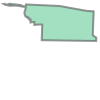

In [5]:
# looks about west point grey
Polygon(combined_boundary_coordinates_wpg)

## 3. Include Stanley Park Boundaries
I've used Overpass API to fetch and combine the boundaries of Stanley Park .

In [6]:
# Stanley Park 

# Use Overpass API to get boundaries
way_id_sp1 = 37063023
coordinates_sp1 = neighborhood_boundaries.get_boundary_by_way_id(way_id_sp1)
park_polygon_sp1 = neighborhood_boundaries.create_park_polygon_from_coordinates(coordinates_sp1)

way_id_sp2 = 37056115
coordinates_sp2 = neighborhood_boundaries.get_boundary_by_way_id(way_id_sp2)
park_polygon_sp2 = neighborhood_boundaries.create_park_polygon_from_coordinates(coordinates_sp2)

combined_park_polygon_sp = park_polygon_sp1.union(park_polygon_sp2)
x_combined_sp, y_combined_sp = combined_park_polygon_sp.exterior.xy
combined_boundary_coordinates_sp = list(zip(x_combined_sp, y_combined_sp))

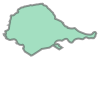

In [7]:
# looks like stanley park
Polygon(combined_boundary_coordinates_sp)

## 4. Create Updated GeoJSON Features and Svae the Final GeoJSON
I've create new GeoJSON features for the expanded West Point Grey and Stanley Park boundaries. Then, merge the updated boundaries back into the original dataset and save the result.

In [8]:
sp_geomjson = neighborhood_boundaries.create_geojson_feature(
    combined_boundary_coordinates_sp, 
    "Stanley Park", 
    center_lon=sum(coord[0] for coord in combined_boundary_coordinates_sp) / len(combined_boundary_coordinates_sp), 
    center_lat=sum(coord[1] for coord in combined_boundary_coordinates_sp) / len(combined_boundary_coordinates_sp)
)


wpg_geomjson = neighborhood_boundaries.create_geojson_feature(
    combined_boundary_coordinates_wpg, 
    "West Point Grey", 
    center_lon=sum(coord[0] for coord in combined_boundary_coordinates_wpg) / len(combined_boundary_coordinates_wpg), 
    center_lat=sum(coord[1] for coord in combined_boundary_coordinates_wpg) / len(combined_boundary_coordinates_wpg)
)

final_boundaries = neighborhood_boundaries.merge_geojsons(
    neighborhood_boundaries.filter_out_west_point_grey(geojson_data), 
    neighborhood_boundaries.merge_geojsons(sp_geomjson, wpg_geomjson)
)

neighborhood_boundaries.save_geojson(final_boundaries, "../data/processed/local_area_boundary.geojson")

Error writing to file: [Errno 2] No such file or directory: '../data/processed/local_area_boundary.geojson'


# Done! :)